In [1]:
import methylprep
import methylcheck
import pandas as pd
from pathlib import Path
import numpy as np

In [2]:
#data = np.array(probes, dtype=None, copy=True, order='K', subok=False, ndmin=0)
#np.save('illumina_sketchy_probes_996.npy',data, allow_pickle=False)
#data2 = np.load('illumina_sketchy_probes_996.npy', allow_pickle=False)

In [3]:

sketchy_probes = np.load(Path('/Users/mmaxmeister/methylcheck/methylcheck/data_files/illumina_sketchy_probes_996.npy'))
filelist = list(Path('/Volumes/LEGX/GEO/epic-beta').glob('*.pkl'))

filenames = [
    '/Volumes/LEGX/GEO/GSE74013/GSE74013_beta_values.pkl', # .gz
    '/Volumes/LEGX/GEO/GSE146376/beta_values_1.pkl',
    '/Volumes/LEGX/GEO/GSE117860_beta_values.pkl',
    '/Volumes/LEGX/GEO/GSE133355/GPL21145/GSE133355_beta_values.pkl',
    '/Volumes/LEGX/GEO/GSE72556/GPL13534/GSE72556_beta_values.pkl', 
]

def test_files(filenames):
    for filename in filenames:
        df = methylcheck.load(filename, verbose=True)    
        methylcheck.sample_plot(df)
        #bad = df[df.index.isin(sketchy_probes)]
        #print(f'{bad.shape} bad probes for {Path(filename).name}')
        #methylcheck.sample_plot(bad)
        break

#df = methylcheck.load('/Volumes/LEGX/Barnes/test/beta_values.pkl', verbose=True, pval_cutoff=0.01)

Files:   0%|          | 0/1 [00:00<?, ?it/s]INFO:methylcheck.load_processed:/Volumes/LEGX/Barnes/test/beta_values.pkl
INFO:methylcheck.load_processed:Probes: 865859
Files: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
INFO:methylcheck.load_processed:loaded data (865859, 2) from 1 pickled files (1.298s)


2it [00:05,  2.53s/it]


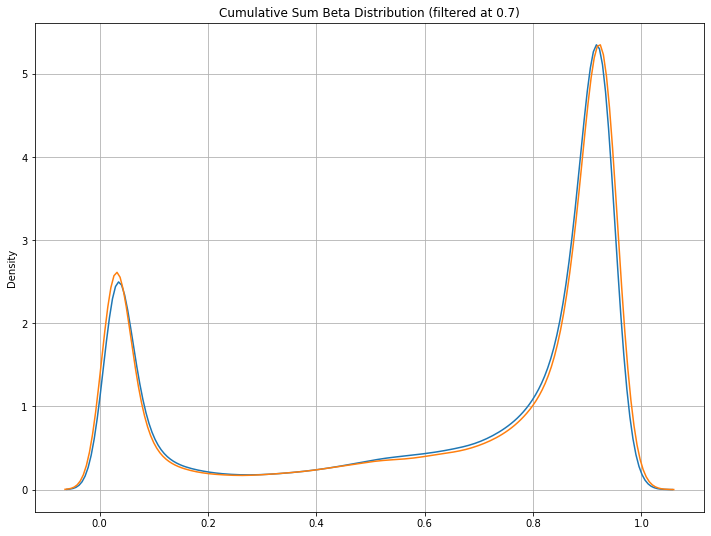

IlmnID,cg07881041,cg23229610,cg03513874,cg14797042,cg25458538,cg09261072,cg02404579,cg04118974,cg01236347,cg22585117,...,cg22003366,cg20742182,cg09073105,cg16416806,cg22005990,cg05384275,cg21496658,cg10218605,cg22494081,cg22623303
201414140173_R07C01,0.925,0.928,0.944,0.946,0.934,0.667,0.898,0.729,0.794,0.914,...,0.056,0.204,0.045,0.036,0.154,0.021,0.022,0.405,0.960,0.975
201414140173_R08C01,0.935,0.929,0.946,0.942,0.940,0.664,0.928,0.748,0.780,0.933,...,0.046,0.176,0.039,0.028,0.105,0.016,0.017,0.374,0.969,0.974


In [22]:
# -*- coding: utf-8 -*-
# built ins
import logging
import os
import datetime

# package
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# because sklearn is a HUGE library and we're only using a single function from it,
# I've embedded the code we need in a local file. This makes methylcheck small enough to run in AWS lambda,
# but it won't use our local code copy if sklearn is installed in the environment. Just a fallback / low-env option.
try:
    from sklearn.manifold import MDS
except (ImportError, ModuleNotFoundError):
    from .sklearn_mds import *
#app
from methylcheck.progress_bar import * # tqdm, environment-specific import
from methylcheck.probes.filters import drop_nan_probes
## TODO unit-testing:
## combine_mds and ._load_data are not tested

LOGGER = logging.getLogger('__NAME__')

def beta_density_plot(df, verbose=False, save=False, silent=False, reduce=0.1, plot_title=None, ymax=None, return_fig=False, full_range=False, highlight_samples=None, figsize=(12,9), show_labels=None, filename='beta.png'):
    """Returns a plot of beta values for each sample in a batch of samples as a separate line.
    Y-axis values is the count (of what? intensity? normalized?).
    X-axis values are beta values (0 to 1) for a single samples

    Input (df):
        - a dataframe with probes in rows and sample_ids in columns.
        - to get this formatted import, use `methylprep.consolidate_values_for_sheet()`,
        as this will return a matrix of beta-values for a batch of samples (by default).

    Returns:
        None
        (but if return_fig is True, returns the figure object instead of showing plot)

    Parameters:
        verbose:
            display extra messages
        save:
            if True, saves a copy of the plot as a png file.
        silent:
            if True, eliminates all messages (useful for automation and scripting)
        reduce:
            when working with datasets and you don't need publication quality "exact" plots,
            supply a float between 0 and 1 to sample the probe data for plotting.
            We recommend 0.1, which plots 10% of the 450k or 860k probes, and doesn't distort
            the distribution much. Values below 0.001 (860 probes out of 860k) will show some sampling distortion.
            Using 0.1 will speed up plotting 10-fold of large batches.
        ymax (None): If defined, upper limit of plot will not exceed this value. But it y-range can be smaller if values are less than this range.
        full_range: (False) if True, x-axis will be auto-scaled, instead of fixed in the 0-to-1.0 range.
        return_fig: (False) if True, returns figure object instead of showing plot.

        highlight_samples: a string or list of df col-names that, if provided, will highlight sample(s) in blue and bold in plot returned. all other samples in df will be grayed out. Useful for QC reports.
        figsize: tuple of width, height, with 12,9 being default if ommitted.
        show_labels: By default, sample names appear in a legend if there are <30 samples. Otherwise, ommitted. Use this to force legend on or off.

    Note:
        if the sample_ids in df.index are not unique, it will make them so for the purpose of plotting.
     """
    # ensure sample ids are unique
    if df.shape[0] > df.shape[1]:
        df = df.transpose()
        # must have samples in rows/index to reindex. you can't "recolumn".
        if len(list(df.index)) != len(list(set(df.index))):
            LOGGER.info("Your sample ids contain duplicates.")
            # rename these for this plot only
            df['ids'] = df.index.map(lambda x: x + '_' + str(int(1000000*np.random.rand())))
            df = df.set_index('ids', drop=True)
            df = df.transpose()

    if df.shape[0] < df.shape[1]:
        ## ensure probes in rows and samples in cols
        if verbose:
            LOGGER.info("Your data needed to be transposed (df = df.transpose()).")
        df = df.transpose()
    # 2nd check: incomplete probes
    if df.shape[0] < 27000:
        LOGGER.warning("Data does not appear to be full probe data")
    # 3rd check: missing probe values (common with EPIC+ and p-value)
    pre_probe_count = df.shape[0]
    missing_probes = sum(df.isna().sum())
    if missing_probes > 0 and silent:
        df = df.copy().dropna()
    elif missing_probes > 0 and not verbose:
        LOGGER.warning(f"Your data contains {int(missing_probes/len(df.columns))} missing probe values per sample, ({missing_probes} overall). For a list per sample, use verbose=True")
        df = df.copy().dropna()
    elif missing_probes > 0 and verbose:
        LOGGER.warning(f"Your data contains {int(missing_probes/len(df.columns))} missing probe values per sample, ({missing_probes} overall).")
        LOGGER.info(df.isna().sum())
        df = df.copy().dropna()
    if df.shape[0] < 2:
        print(f"ERROR: Could not plot these samples because there are missing values for each probe in at least one sample in the batch: Started with {pre_probe_count} probes and ended with {df.shape[0]} probes shared after filtering.")
        return

    if reduce != None and reduce < 1.0:
        if not isinstance(reduce, (int, float)):
            try:
                reduce = float(reduce)
            except Exception as e:
                raise ValueError(f"{reduce} must be a floating point number between 0 and 1.0")
        # the fraction of probes in index (rows) to include in plot.
        # speeds plotting up a TON.
        # choice returns the positions as a list.
        probes = np.random.choice(df.shape[0], int(reduce*df.shape[0]))

    fig, ax = plt.subplots(figsize=figsize)

    if show_labels is None: # user-param-always overrides this.
        show_labels = True if len(df.columns) <= 30 else False
    for col in df.columns: # samples
        if col not in ('Name','ID_REF'): # probe name
            if reduce == 1.0:
                values = df[col].values
            elif reduce != None and 0 < reduce < 1.0:
                values = df[col].values[probes]
            else:
                values = df[col].values
            if len(values.shape) > 1:
                raise ValueError("Your df probaby contains duplicate sample names.")

            kde_kws = None # optional, conditional color highlighting for one or several samples in the DF, using the "highlight_samples" list passed in.
            if highlight_samples not in (None,[]):
                kde_kws={"color": "lightgray", "linewidth": 3} #, "lw": 1}
                if isinstance(highlight_samples, str) and col == highlight_samples:
                    kde_kws.update({"color":"b", "linewidth":0, "fill": True}) #, "lw":3})
                if isinstance(highlight_samples, list) and col in highlight_samples:
                    kde_kws.update({"color":"b", "linewidth":0, "fill":True}) #, "lw":3})

            #kwargs = {"hist":False, "rug":False, "kde":True, "ax":ax, "axlabel":'beta'}
            kwargs = {"ax":ax}
            if kde_kws:
                #kwargs["kde_kws"] = kde_kws
                kwargs.update(kde_kws)
            if show_labels:
                kwargs["label"] = col

            if values.shape[0] < 2:
                if verbose:
                    print(f"Skipping blank sample {values}")
                continue
            #sns.displot(values, **kwargs)
            sns.kdeplot(values, **kwargs)

    (obs_ymin, obs_ymax) = ax.get_ylim()
    #if verbose: #DEBUG for if plot is blank
    #    print(values.shape, kwargs, obs_ymin, obs_ymax)

    if ymax is not None and obs_ymax > ymax:
        ax.set_ylim(0, ymax)
    if show_labels:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #else:
    #    ax.get_legend().set_visible(False)
    #    print('suppressing legend')
    
    plt.title(plot_title or 'Beta Density Plot')
    plt.grid()
    if not full_range:
        plt.xlim(0,1.0)
    plt.xlabel('Beta values')
    
    if save:
        plt.savefig(filename)
    if return_fig:
        return fig
    if not silent:
        plt.show()
        plt.clf()
        plt.cla()
        plt.close()        
    else:
        plt.clf()
        plt.cla()
        plt.close()

#beta_density_plot(df, show_labels=None, highlight_samples='201414140173_R07C01')

def cumulative_sum_beta_distribution(df, cutoff=0.7, verbose=False, save=False, silent=False):
    """ attempts to filter outlier samples based on the cumulative area under the curve
    exceeding a reasonable value (cutoff).

    Inputs:
        DataFrame -- wide format (probes in columns, samples in rows)
        cutoff (default 0.7)
        silent -- suppresses figure, so justs returns transformed data if False.
        if save==True: saves figure to disk.

    Returns:
        dataframe with subjects removed that exceed cutoff value."""
    # ensure probes in colums, samples in rows
    if df.shape[1] < df.shape[0]:
        df = df.copy().transpose() # don't overwrite the original
        if verbose:
            print("Your data needed to be transposed (df = df.transpose()).")
            LOGGER.info("Your data needed to be transposed (df = df.transpose()).")

    good_samples = []
    outliers = []
    if verbose:
        print("Calculating area under curve for each sample.")
    fig, ax = plt.subplots(figsize=(12, 9))
    # first, check if probes aren't consistent, to avoid a crash here
    df = drop_nan_probes(df, silent=silent, verbose=verbose)

    # if silent is True, tqdm will not show process bar.
    for subject_num, (row, subject_id) in tqdm(enumerate(zip(df.values,
                                                             df.index)), disable=silent):
        hist_vals = np.histogram(row, bins=10)[0]
        hist_vals = hist_vals / np.sum(hist_vals)
        cumulative_sum = np.cumsum(hist_vals)
        if cumulative_sum[5] < cutoff:
            good_samples.append(subject_num)
            #sns.distplot(row, hist=False, norm_hist=False)
            sns.kdeplot(row)
        else:
            outliers.append(subject_id) # drop uses ids, not numbers.

    plt.title('Cumulative Sum Beta Distribution (filtered at {0})'.format(cutoff))
    plt.grid()
    if len(df.columns) <= 30:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        ax.legend_ = None
    if save:
        plt.savefig('cum_beta.png')
    if not silent:
        plt.show()
    plt.clf()
    plt.cla()
    plt.close()
    return df.drop(outliers, axis=0)

def drop_nan_probes(df, silent=False, verbose=False):
    """ accounts for df shape (probes in rows or cols) so dropna() will work.

    the method used inside MDS may be faster, but doesn't tell you which probes were dropped."""
    ### histogram can't have NAN values -- so need to exclude before running, or warn user.
    # from https://dzone.com/articles/pandas-find-rows-where-columnfield-is-null -- returns a slimmer df of col/rows with NAN.
    dfnan = df[df.isnull().any(axis=1)][df.columns[df.isnull().any()]]
    if len(dfnan) > 0 and df.shape[0] > df.shape[1]: # a list of probe names that contain nan.
        #probes in rows
        pre_shape = df.shape
        df = df.dropna()
        note = "(probes,samples)"
        if not silent and verbose and len(dfnan) < 200:
            LOGGER.info(f"Dropped {len(dfnan)} probe(s) that are missing for this calculation: {dfnan}")
            LOGGER.info(f"Retained {df.shape} {note} from the original {pre_shape} {note}.")
        elif not silent and verbose and len(dfnan) >= 200:
            LOGGER.info(f"Dropped {len(dfnan)} probes; retained {df.shape} {note} from the original {pre_shape} {note}.")
    elif len(dfnan.columns) > 0 and df.shape[1] > df.shape[0]:
        pre_shape = df.shape
        df = df.dropna(axis='columns')
        note = "(samples,probes)"
        if not silent and verbose and len(dfnan.columns) < 200:
            LOGGER.info(f"Dropped {len(dfnan.columns)} probe(s) that are missing for this calculation: {dfnan.columns}")
            LOGGER.info(f"Retained {df.shape} {note} from the original {pre_shape} {note}.")
        elif not silent and verbose and len(dfnan.columns) >= 200:
            LOGGER.info(f"Dropped {len(dfnan.columns)} probes; retained {df.shape} {note} from the original {pre_shape} {note}.")
    return df

cumulative_sum_beta_distribution(df)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


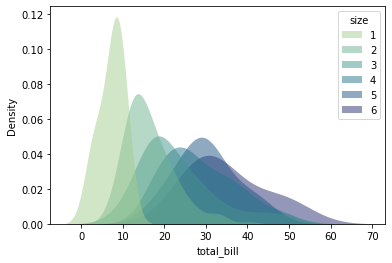

In [5]:
tips =sns.load_dataset("tips")
sns.kdeplot(
   data=tips, x="total_bill", hue="size",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0,
)
plt.show
tips

True

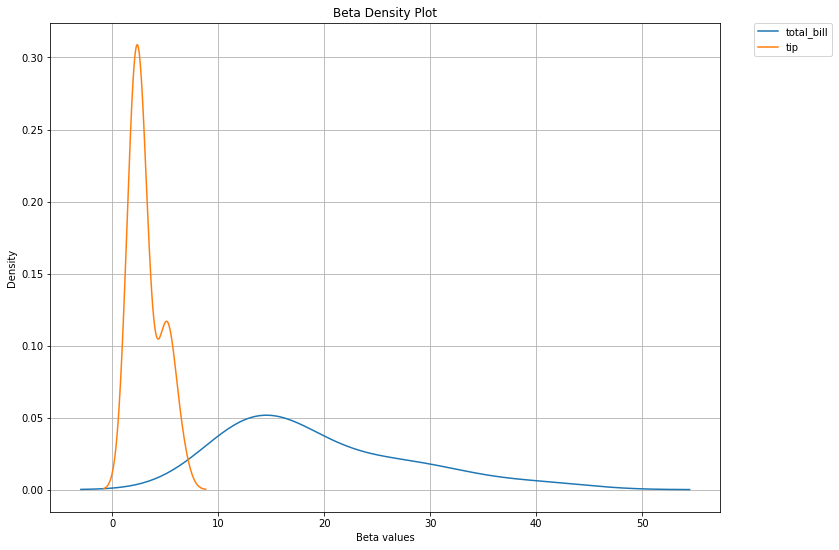

In [15]:
fig = methylcheck.beta_density_plot(tips[['total_bill','tip']], return_fig=True, full_range=True, show_labels=None, filename='beta.png')
import matplotlib
isinstance(fig, matplotlib.figure.Figure)

Files: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
INFO:methylcheck.load_processed:loaded data (865859, 32) from 1 pickled files (0.338s)
Files: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]
INFO:methylcheck.load_processed:loaded data (485512, 96) from 1 pickled files (0.464s)


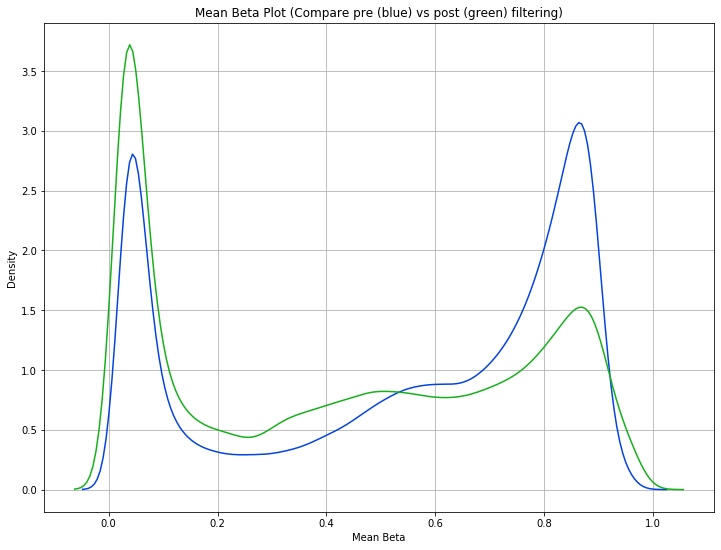

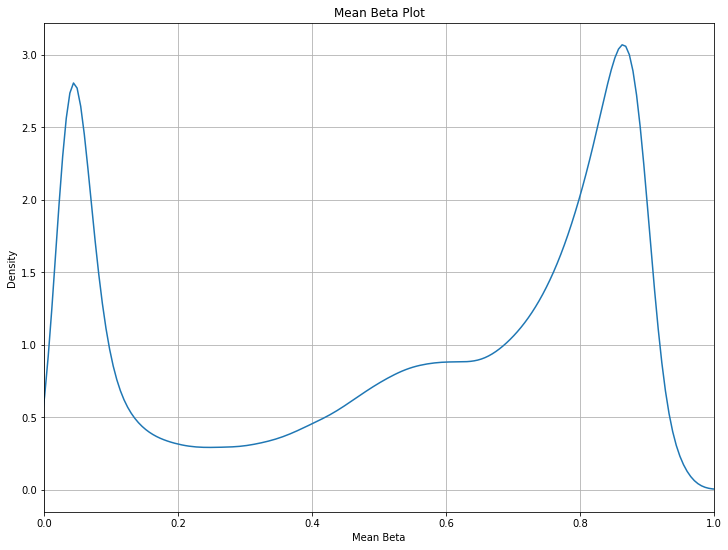

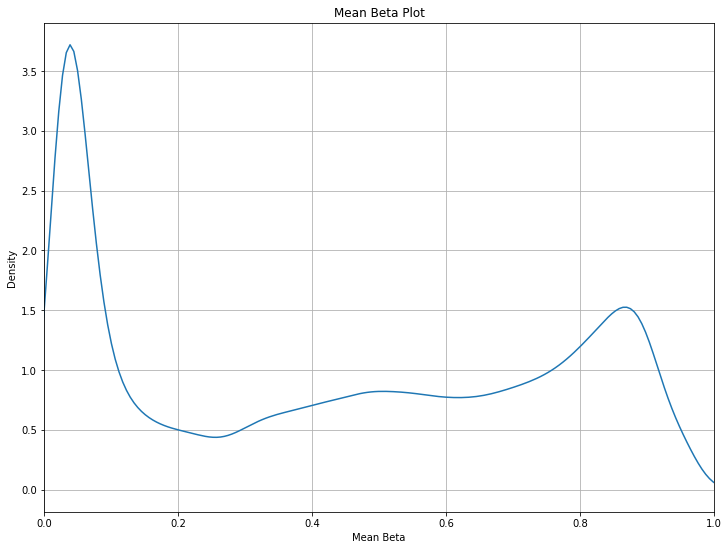

In [24]:
def mean_beta_compare(df1, df2, save=False, verbose=False, silent=False):
    """Use this function to compare two dataframes, pre-vs-post filtering and removal of outliers.

    silent: suppresses figure, so no output unless save==True too."""
    if df1.shape[0] < df1.shape[1]:
        ## ensure probes in rows and samples in cols
        if verbose:
            print("Your first data set needed to be transposed (df = df.transpose()).")
            LOGGER.info("Your data needed to be transposed (df = df.transpose()).")
        df1 = df1.copy().transpose() # don't overwrite the original
    if df2.shape[0] < df2.shape[1]:
        ## ensure probes in rows and samples in cols
        if verbose:
            print("Your second data set needed to be transposed (df = df.transpose()).")
            LOGGER.info("Your data needed to be transposed (df = df.transpose()).")
        df2 = df2.copy().transpose() # don't overwrite the original

    data1 = df1.copy(deep=True)
    data1['mean'] = data1.mean(numeric_only=True, axis=1)
    data2 = df2.copy(deep=True)
    data2['mean'] = data2.mean(numeric_only=True, axis=1)

    fig, ax = plt.subplots(figsize=(12, 9))
    #line1 = sns.distplot(data1['mean'], hist=False, rug=False, ax=ax, axlabel='beta', color='xkcd:blue')
    #line2 = sns.distplot(data2['mean'], hist=False, rug=False, color='xkcd:green')
    line1 = sns.kdeplot(data1['mean'], ax=ax, label='beta', color='xkcd:blue')
    line2 = sns.kdeplot(data2['mean'], color='xkcd:green')
    plt.title('Mean Beta Plot (Compare pre (blue) vs post (green) filtering)')
    plt.grid()
    plt.xlabel('Mean Beta')
    #plt.legend([line1, line2], ['pre','post'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save:
        plt.savefig('mean_beta_compare.png')
    if not silent:
        plt.show()
    else:
        plt.close('all')

df1= methylcheck.load('/Volumes/LEGX/GEO/GSE133355/GPL21145/GSE133355_beta_values.pkl')
df2= methylcheck.load('/Volumes/LEGX/GEO/GSE72556/GPL13534/GSE72556_beta_values.pkl')

mean_beta_compare(df1, df2)

def mean_beta_plot(df, verbose=False, save=False, silent=False):
    """Returns a plot of the average beta values for all probes in a batch of samples.

    Input (df):
        - a dataframe with probes in rows and sample_ids in columns.
        - to get this formatted import, use `methylprep.consolidate_values_for_sheet()`,
        as this will return a matrix of beta-values for a batch of samples (by default)."""
    if df.shape[0] < df.shape[1]:
        ## ensure probes in rows and samples in cols
        if verbose:
            print("Your data needed to be transposed (df = df.transpose()).")
            LOGGER.info("Your data needed to be transposed (df = df.transpose()).")
        df = df.copy().transpose() # don't overwrite the original

    data = df.copy(deep=True)
    data['mean'] = data.mean(numeric_only=True, axis=1)
    fig, ax = plt.subplots(figsize=(12, 9))
    #sns.distplot(data['mean'], hist=False, rug=False, ax=ax, axlabel='beta')
    sns.kdeplot(data['mean'], ax=ax, label='beta')
    plt.title('Mean Beta Plot')
    plt.grid()
    plt.xlim(0,1.0)
    plt.xlabel('Mean Beta')
    if save:
        plt.savefig('mean_beta.png')
    if not silent:
        plt.show()
    else:
        plt.close(fig)

mean_beta_plot(df1)
mean_beta_plot(df2)

INFO:__NAME__:Your sample ids contain duplicates.


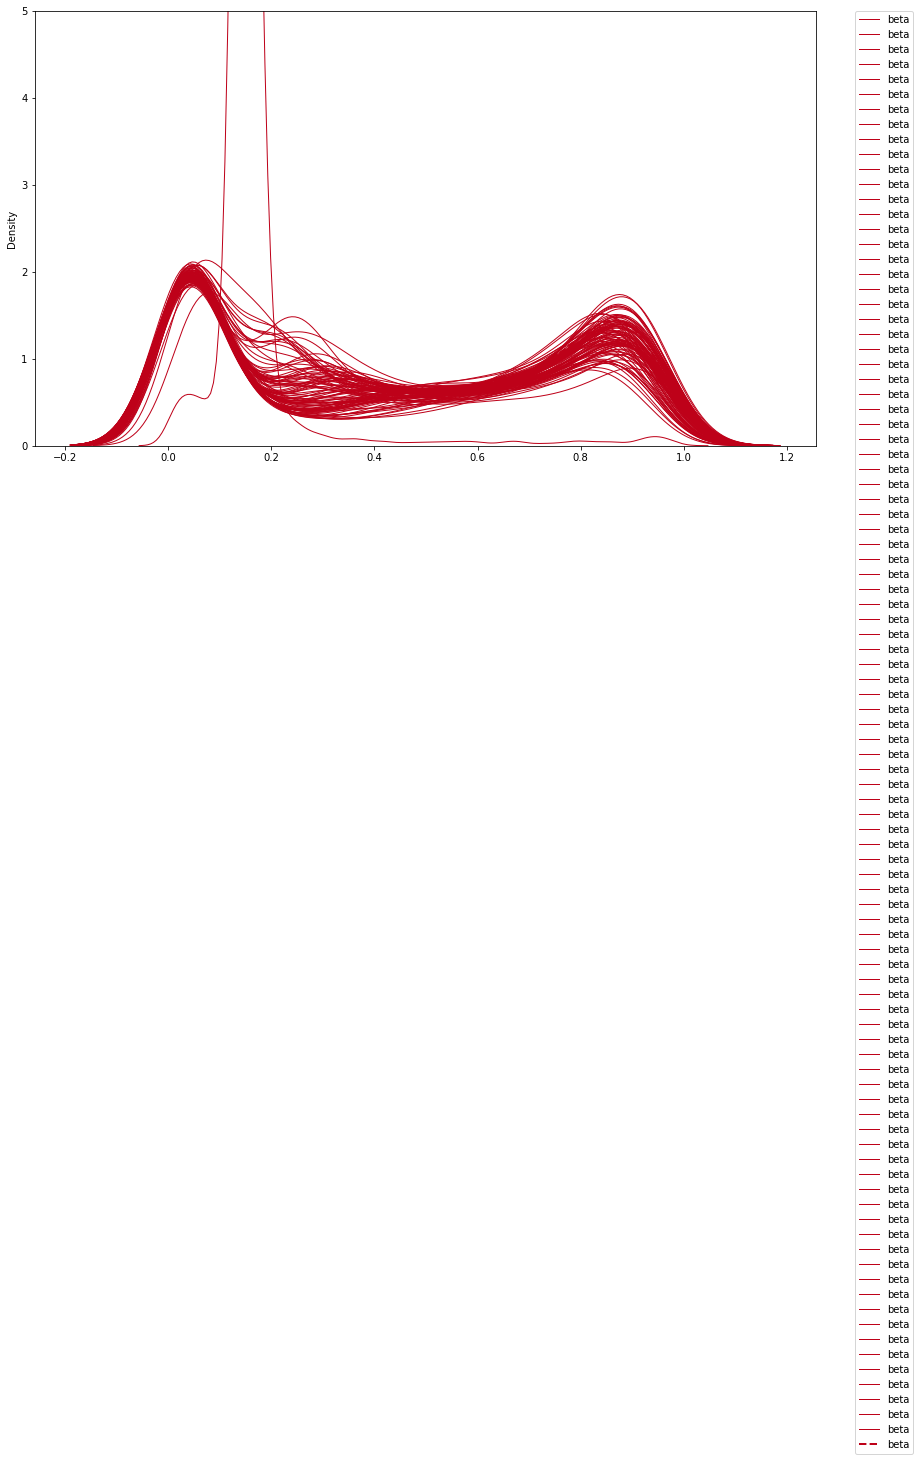

In [28]:
colors = {-1:"xkcd:scarlet", 2:'xkcd:brick red', 1:"xkcd:blue", 2:"xkcd:green", 3:'xkcd:gold', 4:'xkcd:purple', 5:'xkcd:grey blue',
    6:'xkcd:brown', 7:'xkcd:bubblegum', 8:'xkcd:tangerine', 9:'xkcd:poop', 10:"xkcd:baby blue", 11:"xkcd:violet", 12:"xkcd:apple green",
    13:"xkcd:neon pink", 14:"xkcd:deep green", 15:"xkcd:blush", 16:"xkcd:lemon"}

def sample_plot_color_clusters(df, colormap=None, verbose=False, save=False, silent=False, reduce=0.01, ymax=5, figsize=(14,8)):
        """ colormap: dict of sample_ids --> group number (some int). Sample_ids must match df columns"""
        #qualitative_colors = sns.color_palette("Set3", 10)
        #sns.set_color_codes()
        # ensure sample ids are unique
        if df.shape[0] > df.shape[1]:
            df = df.transpose()
            # must have samples in rows/index to reindex. you can't "recolumn".
            if list(df.index) != list(set(df.index)):
                LOGGER.info("Your sample ids contain duplicates.")
                # rename these for this plot only
                df['ids'] = df.index.map(lambda x: x + '_' + str(int(1000000*np.random.rand())))
                df = df.set_index('ids', drop=True)
                df = df.transpose()

        if df.shape[0] < df.shape[1]:
            ## ensure probes in rows and samples in cols
            df = df.transpose()
        if reduce != None and reduce < 1.0:
            if not isinstance(reduce, (int, float)):
                try:
                    reduce = float(reduce)
                except Exception as e:
                    raise ValueError(f"{reduce} must be a floating point number between 0 and 1.0")
            probes = np.random.choice(df.shape[0], int(reduce*df.shape[0]))
        fig, ax = plt.subplots(figsize=figsize) #was (12, 9)
        for idx, sample_id in enumerate(df.columns): # samples
            if sample_id != 'Name': # probe name
                if reduce:
                    values = df[sample_id].values[probes]
                else:
                    values = df[sample_id].values
                if len(values.shape) > 1:
                    raise ValueError("Your df probaby contains duplicate sample names.")

                this_color = colors[-1] if colormap is None else colors.get(colormap.get(sample_id,-1),'k')
                if idx+1 == len(df.columns):
                    kde_kws = {'linestyle':'--', 'linewidth':2}
                else:
                    kde_kws = {'linewidth':1}

                #sns.distplot(
                #    values, hist=False, rug=False, kde=True,
                #    ax=ax, axlabel='beta', color=this_color, kde_kws=kde_kws)
                sns.kdeplot(values, ax=ax, label='beta', color=this_color, **kde_kws)
        (data_ymin,data_ymax) = ax.get_ylim()
        if data_ymax > ymax:
            ax.set_ylim(0,ymax)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

sample_plot_color_clusters(df2, colormap={'9934987052_R01C01':1, '9934987052_R01C02':2})